In [11]:
import os
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [12]:
DATA_DIR = './dms_data'
def load_and_preprocess_data(file_path):
    """CSVを読み込んでちょっと前処理する関数。"""
    df = pd.read_csv(file_path)
    df = df.drop(['timestamp'], axis=1)
    return df.dropna()

def get_data_from_directory(directory_path):
    """指定ディレクトリのCSV全部を読み込んで結合する関数。"""
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
    return pd.concat(data_frames, ignore_index=True)

def showLgbmModelFeature(model):
    plt.figure(figsize=(10,6))
    lgb.plot_importance(model)
    plt.show()

# トレインデータとテストデータを読み込む
train = get_data_from_directory(os.path.join(DATA_DIR, 'train'))
test = get_data_from_directory(os.path.join(DATA_DIR, 'test'))

# 特徴量を定義
features = [
    'm_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480'
]

In [13]:
def evaluate_predictions(predicted_labels, true_labels):
    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Other statistics (Precision, Recall, F1-score)
    print("\nClassification Report:\n")
    print(classification_report(true_labels, predicted_labels))

    return acc

# 使用例
# acc_value = evaluate_predictions(predicted_labels, y_test_oss)


In [14]:
# ossを丸めてint型として新しいカラムoss_intを追加
train['int_oss'] = train['oss'].round().astype(int)
train['int_sleepiness'] = train['Sleepiness'].round().astype(int)
test['int_oss'] = test['oss'].round().astype(int)
test['int_sleepiness'] = test['Sleepiness'].round().astype(int)

### LightGBM

In [15]:
def train_lgbm_classificatoin(num_class,train,test):
    params = {
    'objective': 'multiclass', # 多クラス分類
    'num_class': num_class, # クラスの数
    'metric': 'multi_logloss' # 損失関数にmulti_loglossを使用
    }
    model = lgb.train(params, train, num_boost_round=1000, valid_sets=[train,test], early_stopping_rounds=10)
    return model


/home/buntin/jupyter-env/lib64/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5462
[LightGBM] [Info] Number of data points in the train set: 1738, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.491783
[LightGBM] [Info] Start training from score -0.573959
[LightGBM] [Info] Start training from score -1.847362
[LightGBM] [Info] Start training from score -2.917196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's multi_logloss: 0.947342	valid_1's multi_logloss: 1.40269
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 0.841149	valid_1's multi_logloss: 1.3184

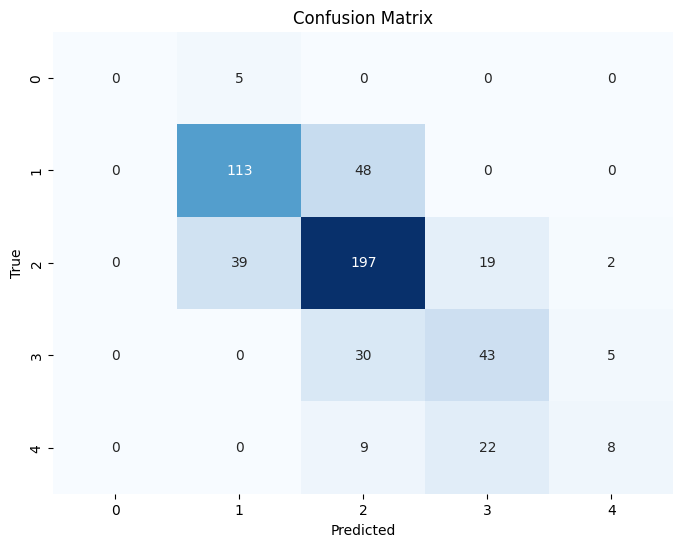


Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.72      0.70      0.71       161
           3       0.69      0.77      0.73       257
           4       0.51      0.55      0.53        78
           5       0.53      0.21      0.30        39

    accuracy                           0.67       540
   macro avg       0.49      0.44      0.45       540
weighted avg       0.66      0.67      0.66       540



/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# int_oss
from sklearn.metrics import accuracy_score

X_train_oss = train.drop('int_oss', axis=1).drop('oss',axis=1)
y_train_oss = train['int_oss']
y_train_oss -= 1

X_test_oss = test.drop('int_oss', axis=1).drop('oss',axis=1)
y_test_oss = test['int_oss']
y_test_oss -= 1

train_data_oss = lgb.Dataset(X_train_oss, label=y_train_oss)
test_data_oss = lgb.Dataset(X_test_oss, label=y_test_oss, reference=train_data_oss)

model = train_lgbm_classificatoin(5,train_data_oss,test_data_oss)

y_pred_oss = model.predict(X_test_oss)
y_pred_oss_class = np.argmax(y_pred_oss,axis=1) + 1
y_test_oss += 1

acc = accuracy_score(y_test_oss,y_pred_oss_class)
print('Accuracy:', acc)
acc = evaluate_predictions(y_pred_oss_class, y_test_oss)


<Figure size 1000x600 with 0 Axes>

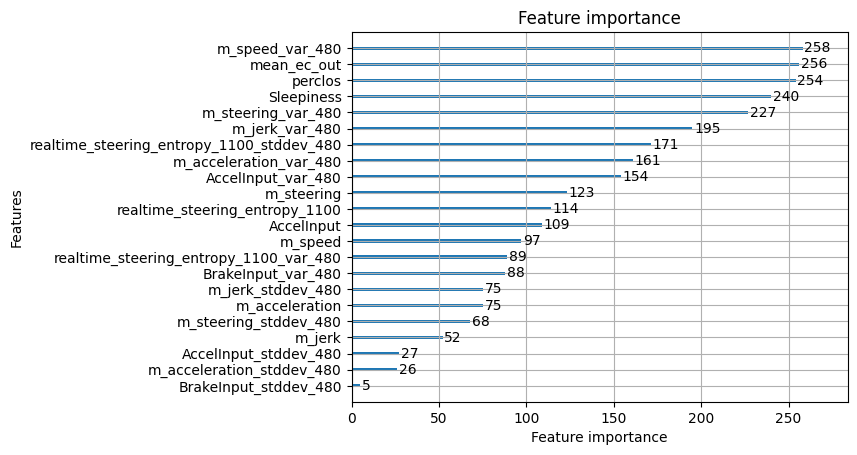

In [17]:
showLgbmModelFeature(model)

/home/buntin/jupyter-env/lib64/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5458
[LightGBM] [Info] Number of data points in the train set: 1738, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -6.767343
[LightGBM] [Info] Start training from score -3.528665
[LightGBM] [Info] Start training from score -2.273104
[LightGBM] [Info] Start training from score -1.733643
[LightGBM] [Info] Start training from score -1.794064
[LightGBM] [Info] Start training from score -1.794064
[LightGBM] [Info] Start training from score -1.829279
[LightGBM] [Info] Start training from score -2.094514
[LightGBM] [Info] Start training from score -2.608460
[LightGBM] [Warning] No further splits with positive gain, best

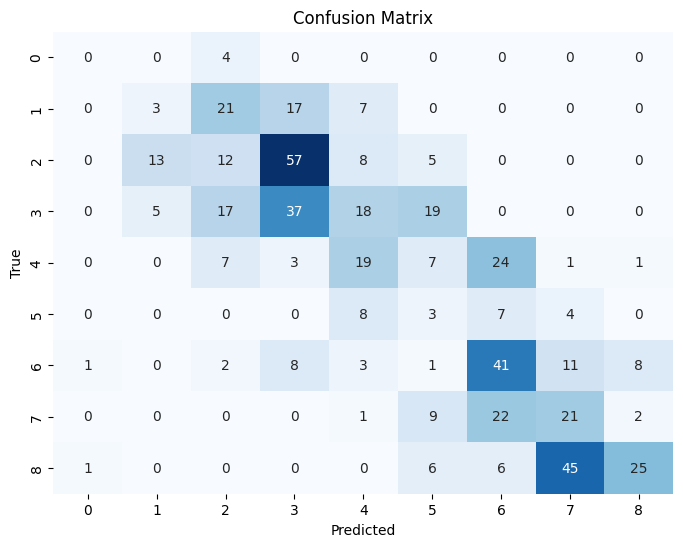


Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.14      0.06      0.09        48
           3       0.19      0.13      0.15        95
           4       0.30      0.39      0.34        96
           5       0.30      0.31      0.30        62
           6       0.06      0.14      0.08        22
           7       0.41      0.55      0.47        75
           8       0.26      0.38      0.31        55
           9       0.69      0.30      0.42        83

    accuracy                           0.30       540
   macro avg       0.26      0.25      0.24       540
weighted avg       0.33      0.30      0.29       540



In [18]:
# int_sleepinessに対するデータセット準備
X_train_sleepiness = train.drop('int_sleepiness', axis=1).drop('Sleepiness',axis=1)
y_train_sleepiness = train['int_sleepiness'] - 1

X_test_sleepiness = test.drop('int_sleepiness', axis=1).drop('Sleepiness',axis=1)
y_test_sleepiness = test['int_sleepiness'] - 1

train_data_sleepiness = lgb.Dataset(X_train_sleepiness, label=y_train_sleepiness)
test_data_sleepiness = lgb.Dataset(X_test_sleepiness, label=y_test_sleepiness, reference=train_data_sleepiness)

model = train_lgbm_classificatoin(9,train_data_sleepiness,test_data_sleepiness)

y_pred_sleepiness = model.predict(X_test_sleepiness)
y_pred_sleepiness_class = np.argmax(y_pred_sleepiness,axis=1) + 1
y_test_sleepiness += 1

acc = accuracy_score(y_test_sleepiness,y_pred_sleepiness_class)
print('Accuracy:', acc)
acc = evaluate_predictions(y_pred_sleepiness_class, y_test_sleepiness)


### NeuralNetwork

Epoch 1/50


44/44 [==============================] - 1s 4ms/step - loss: 2.1997 - accuracy: 0.5216 - val_loss: 1.4486 - val_accuracy: 0.4425
Epoch 2/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9535 - accuracy: 0.6194 - val_loss: 1.5495 - val_accuracy: 0.4195
Epoch 3/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9582 - accuracy: 0.6007 - val_loss: 1.4197 - val_accuracy: 0.4598
Epoch 4/50
44/44 [==============================] - 0s 1ms/step - loss: 1.1168 - accuracy: 0.5806 - val_loss: 1.6417 - val_accuracy: 0.4310
Epoch 5/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.6137 - val_loss: 1.2617 - val_accuracy: 0.4655
Epoch 6/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9366 - accuracy: 0.6115 - val_loss: 1.1744 - val_accuracy: 0.5460
Epoch 7/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9192 - accuracy: 0.6302 - val_loss: 1.3902 - val_accuracy: 0.4540
Epoch 8/50
44/44 [=============

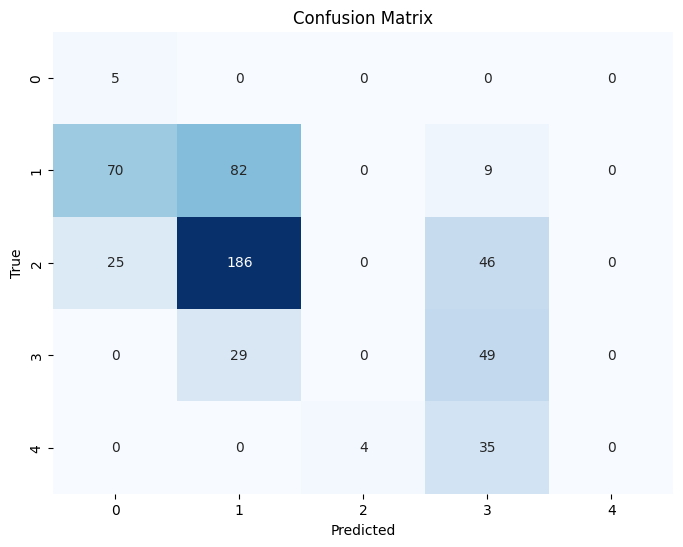


Classification Report:

              precision    recall  f1-score   support

           1       0.05      1.00      0.10         5
           2       0.28      0.51      0.36       161
           3       0.00      0.00      0.00       257
           4       0.35      0.63      0.45        78
           5       0.00      0.00      0.00        39

    accuracy                           0.25       540
   macro avg       0.14      0.43      0.18       540
weighted avg       0.13      0.25      0.17       540

0.2518518518518518


/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# 1. データの準備
X_train_oss = train.drop('int_oss', axis=1).drop('oss',axis=1)
y_train_oss = train['int_oss']

X_test_oss = test.drop('int_oss', axis=1).drop('oss',axis=1)
y_test_oss = test['int_oss']


#1-5を0-4に
y_train_oss_adjusted = y_train_oss - 1
y_test_oss_adjusted = y_test_oss - 1

# ラベルをOne-Hotエンコーディング
num_class = 5
y_train_oss_cat = to_categorical(y_train_oss_adjusted, num_classes=num_class)
y_test_oss_cat = to_categorical(y_test_oss_adjusted, num_classes=num_class)

# 2. モデルの定義
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_oss.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_class, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. モデルのトレーニング
history = model.fit(X_train_oss, y_train_oss_cat, epochs=50, batch_size=32, validation_split=0.2)

# 4. 評価
predictions = model.predict(X_test_oss)
predicted_labels = np.argmax(predictions, axis=1) + 1

# acc = np.mean(predicted_labels == y_test_oss)
# print('Accuracy:', acc)
acc = evaluate_predictions(predicted_labels, y_test_oss)
print(acc)




### GraphNeuralNetwork

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [22]:
def read_and_process(directory):
  files = os.listdir(directory)
  df_list = []
  for file in files:
    if file.endswith('.csv'):
      df = pd.read_csv(os.path.join(directory, file))
      df = df.drop(['timestamp'], axis=1)
      df = df.dropna()
      df_list.append(df)
  df_combined = pd.concat(df_list, ignore_index=True)
  return df_combined

In [23]:
data_dir = 'dms_data'

train_data_path = data_dir + '/train'
test_data_path = data_dir + '/test'


train = read_and_process(train_data_path)
test = read_and_process(test_data_path)
features = ['m_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
            'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
            'm_jerk_var_480', 'm_jerk_stddev_480']

### リカレントニューラルネットワーク(RNN)

Epoch 1/50
44/44 [==============================] - 1s 8ms/step - loss: 1.2082 - accuracy: 0.5914 - val_loss: 1.3102 - val_accuracy: 0.4511
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 1.0590 - accuracy: 0.6029 - val_loss: 1.1779 - val_accuracy: 0.4885
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8767 - accuracy: 0.6388 - val_loss: 0.9672 - val_accuracy: 0.4684
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8154 - accuracy: 0.6360 - val_loss: 0.8719 - val_accuracy: 0.5489
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 0.7947 - accuracy: 0.6388 - val_loss: 0.8607 - val_accuracy: 0.5489
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8294 - accuracy: 0.6273 - val_loss: 0.8748 - val_accuracy: 0.4856
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 0.8108 - accuracy: 0.6460 - val_loss: 0.8611 - val_accuracy: 0.5431
Epoch 8/50
44/44 [==

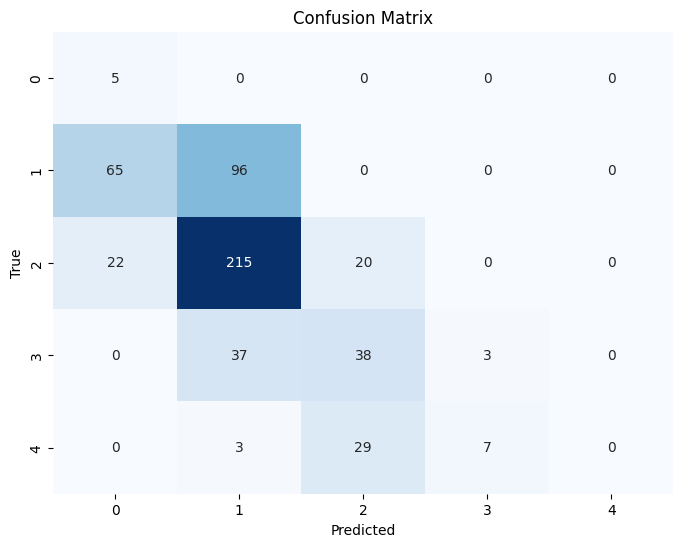


Classification Report:

              precision    recall  f1-score   support

           1       0.05      1.00      0.10         5
           2       0.27      0.60      0.38       161
           3       0.23      0.08      0.12       257
           4       0.30      0.04      0.07        78
           5       0.00      0.00      0.00        39

    accuracy                           0.23       540
   macro avg       0.17      0.34      0.13       540
weighted avg       0.23      0.23      0.18       540

0.22962962962962963


/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:

rnn_model = Sequential()
rnn_model.add(SimpleRNN(64, activation='relu', input_shape=(X_train_oss.shape[1], 1)))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(num_class, activation='softmax'))

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train_oss_rnn = X_train_oss.values.reshape(X_train_oss.shape[0], X_train_oss.shape[1], 1)

history = rnn_model.fit(X_train_oss_rnn, y_train_oss_cat, epochs=50, batch_size=32, validation_split=0.2)

X_test_oss_rnn = X_test_oss.values.reshape(X_test_oss.shape[0], X_test_oss.shape[1], 1)

predictions_rnn = rnn_model.predict(X_test_oss_rnn)
predicted_labels_rnn = np.argmax(predictions_rnn, axis=1) + 1

acc_rnn = evaluate_predictions(predicted_labels_rnn, y_test_oss)
print(acc_rnn)